In [2]:
import pandas as pd
import scipy.io
import numpy as np
from scipy import signal as sg
import matplotlib.pyplot as plt



In [2]:
def create_timeseries(sub,cond,stim):
    """
    compress timeseries of nodes into NxM matrix, where M = number of nodes, and N = number of timepoints
    Returns M * N matrix
    author:Flory Huang 
    Date: 08/29/2022
    """
    #size: 377 * scan length
    timeseries = []
    #read timeseries per nodes
    for i in range(377):
        my_file = open('../data/BPfiltered_mean_timeseries/'+sub+'_BPfiltered_mean_timeseries/'+cond+'_enc_'+stim+'_node'+str(i+1)+'_meants.txt', 'r')
        data = my_file.read()
        ls = data.split('  \n')
        complete_ls = [i for i in ls if i!='' ]
        timeseries.append(complete_ls)
    return np.array(timeseries)

In [3]:
def cosine_similarity(timeseries):
    """
    Function to calculate similarity between timeseries as a
    function of the angle of the complex representation
    Takes NxM matrix, where M = number of timeseries, and 
    N = number of timepoints
    Returns a matrix of size N x M x M
    """
    
    n_ts=timeseries.shape[1]
    n_tp=timeseries.shape[0]
    hilt = sg.hilbert(timeseries,axis=0)
    angles = np.angle(hilt)

    pw_diff=np.array([angles[v,:] - a for v in range(0,n_tp) for a in angles[v,:]])
    pw_diff=np.reshape(pw_diff,[n_tp,n_ts,n_ts])

    cos_sim=np.cos(pw_diff)

    return cos_sim

In [4]:
# calculate network strength for each memory and arousal network
# seperated for both positive and negative network 
# network strength: average hilbert-transformed connectivity strength within network
def create_data():
    for direction in ['pos','neg']:
        cond_ls=['cortisol','placebo']
        stim_ls=['alc','tool']
        sub_ls=["9001","9002","9003","9004","9005","9006","9007","9008","9010","9011","9013","9016","9018","9021","9022","9027","9028","9030","9031","9033","9036","9037" ,"9038","9039","9040","9041"]
        for cond in cond_ls:
            for stim in stim_ls:
                folder="../CPM code/result/5s_onward/"
                
                filename=folder+'n26_RecogAcc_coded_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_'+direction+'.txt'
                data_mem=np.loadtxt(filename,delimiter=',').astype(int)
                filename=folder+'n26_Arous_All_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_'+direction+'.txt'
                data_arous=np.loadtxt(filename,delimiter=',').astype(int)
                
                #remove overlap nodes
                overlap=(data_mem&data_arous)
                data_mem=data_mem&(~overlap)
                data_arous=data_arous&(~overlap)

                nodes=np.nonzero(data_mem)
                length = np.shape(nodes)[1]
                mem_nodes1=nodes[0][:int(length/2)]
                mem_nodes2=nodes[1][:int(length/2)]
                
                nodes=np.nonzero(data_arous)
                length = np.shape(nodes)[1]
                arous_nodes1=nodes[0][:int(length/2)]
                arous_nodes2=nodes[1][:int(length/2)]
                
                network_ls_mem={}
                network_ls_arous={}
                for sub in sub_ls:
                    timeseries = create_timeseries(sub,cond,stim)
                
                    timeseries_t = np.transpose(timeseries)
                    #calculate connectivity matrix time*377*377
                    cos_sim=cosine_similarity(timeseries_t)

                    #get average network strength at each TR 
                    network_conn_mem=[i[mem_nodes1,mem_nodes2].mean() for i in cos_sim]
                    network_ls_mem[sub]=network_conn_mem
                    
                    network_conn_arous=[i[arous_nodes1,arous_nodes2].mean() for i in cos_sim]
                    network_ls_arous[sub]=network_conn_arous
                    
                file_path='data/5s_onward/network_strength/RecogAcc_coded_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_'+direction+'_network_strength_perTR.mat'
                scipy.io.savemat(file_path, network_ls_mem)
                file_path='data/5s_onward/network_strength/Arous_All_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_'+direction+'_network_strength_perTR.mat'
                scipy.io.savemat(file_path, network_ls_arous)

In [5]:
cond_ls=['cortisol','placebo']
stim_ls=['alc','tool']
df_all=pd.read_csv('../data/mem_allsub_alltrial_pill.csv')
df_all['RecogAcc_coded']=df_all['RecogAcc'].apply(lambda x:0 if x==4 else x)


In [6]:
for cond in cond_ls:
    for stim in stim_ls:
            for pheno in ['RecogAcc_coded','Arous_All']:
                file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_'+'pos'+'_network_strength_perTR.mat'
                data=scipy.io.loadmat(file_path)

In [9]:
timewindow=10
sliding=5

for sub in sub_ls:    
    df=df_all[(df_all['Subject']==int(sub))&(df_all['Pill']==cond.title())&(df_all['Stim']==stim)]
    df=df.sort_values('Enc_Trial').reset_index(drop=True)

    file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_'+direction+'_network_strength_perTR.mat'
    data=scipy.io.loadmat(file_path)
    current=data[sub][0]
    conn_ls=[]
    for t in df['Enc_Trial'].values:
        #select timewindow for computing connectivity per trial
        trial_start=df[df['Enc_Trial']==t]['StimOn'].values[0]+sliding
        conn=current[trial_start:trial_start+timewindow]
        conn_ls.append(np.mean(conn))
    df=pd.DataFrame({'conn':conn_ls,'trial_id':df['Enc_Trial'].values,'sub_id':sub,'Pill':cond,'Stim':stim,'direction':direction,'pheno':pheno,pheno:df[pheno].values})
df_ls.append(df)

(1, 530)

In [19]:
create_data()

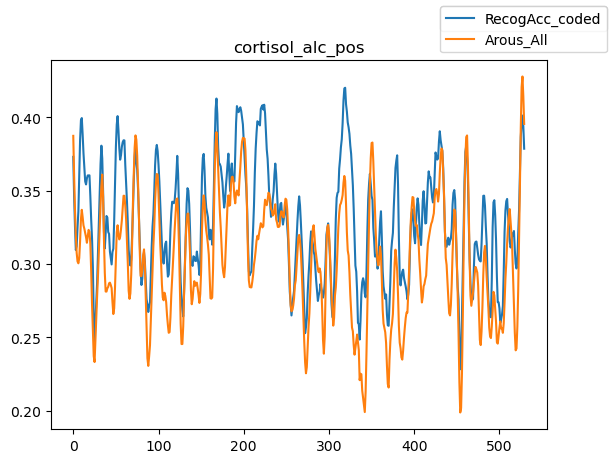

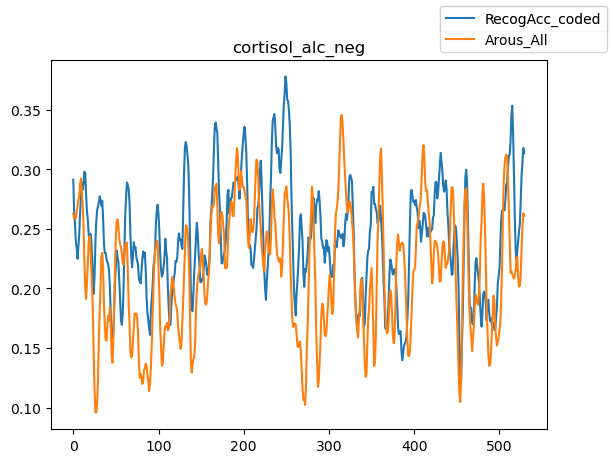

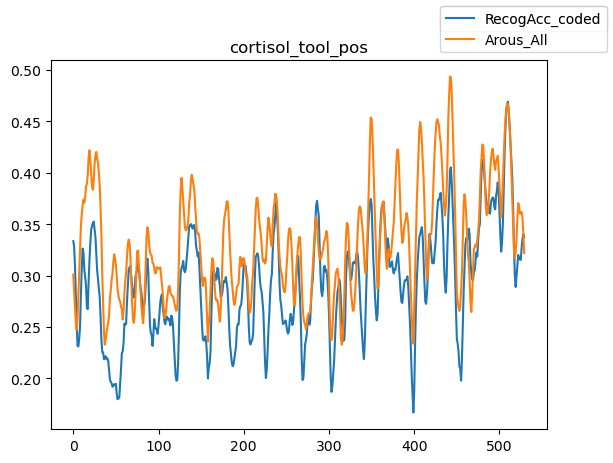

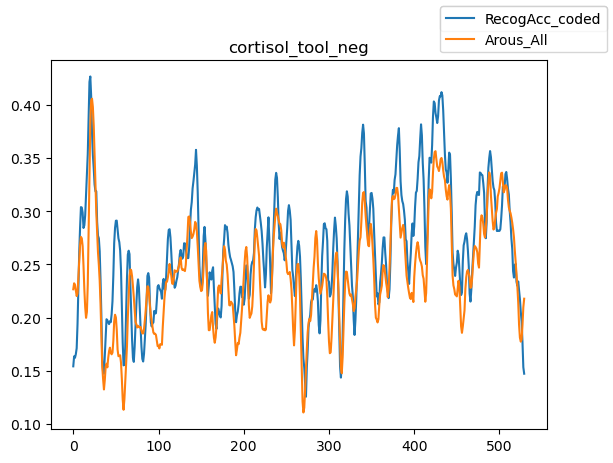

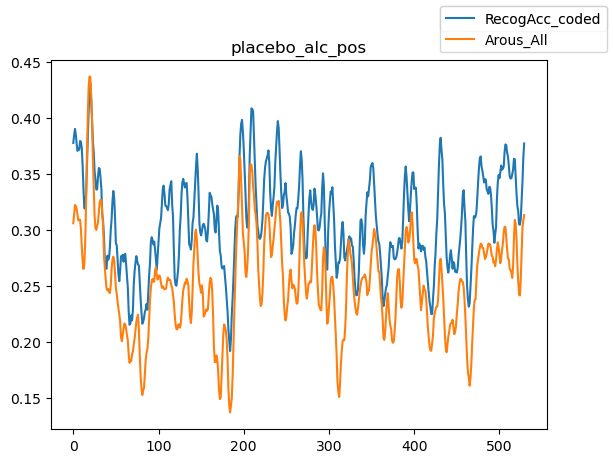

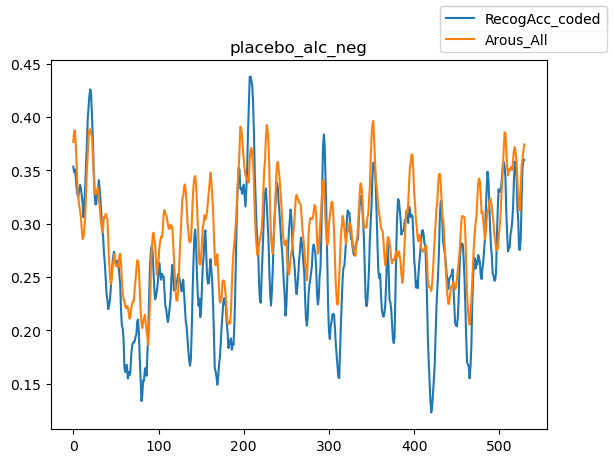

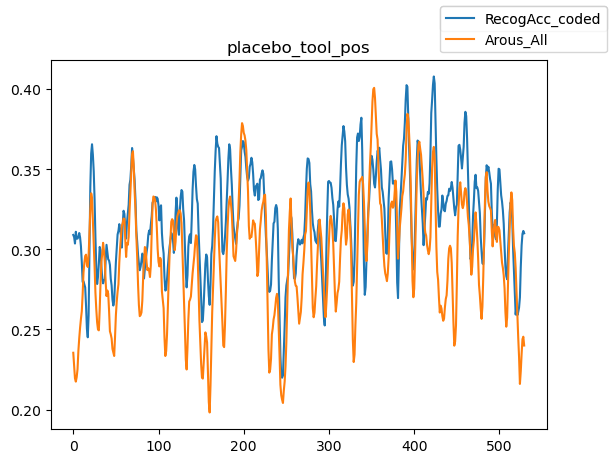

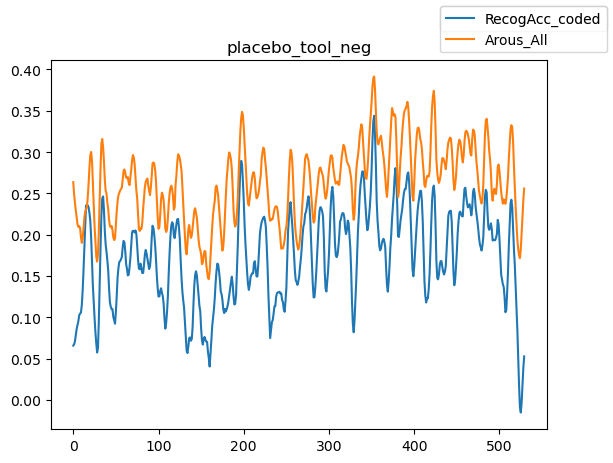

In [234]:
cond_ls=['cortisol','placebo']
stim_ls=['alc','tool']
dic={}

for cond in cond_ls:
    for stim in stim_ls:
        for direction in ['pos','neg']:
            fig, ax = plt.subplots()
            for pheno in ['RecogAcc_coded','Arous_All']:
                file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_'+direction+'_network_strength_perTR.mat'
                data=scipy.io.loadmat(file_path)
                sub_ls=["9001","9002","9003","9004","9005","9006","9007","9008","9010","9011","9013","9016","9018","9021","9022","9027","9028","9030","9031","9033","9036","9037" ,"9038","9039","9040","9041"]
                result=np.array([])
                conn_ls=[]
                for sub in sub_ls:
                    current=data[sub][0]
                    if np.size(current)<530:
                        current=np.pad(current,(0,530-np.size(current)),'constant',constant_values=np.nan)
                    if np.sum(np.where(current<-1))>0:
                        wrong_index=np.where(results<-1)[0]
                        print(wrong_index)
                    conn_ls.append(current)
                conn_ls=np.array(conn_ls)
                results=np.nanmean(np.array(conn_ls),axis=0)

                ax.plot(results,label=pheno)
                ax.ticklabel_format(useOffset=False,style='plain')
                fig.legend()
                dic[cond+'_'+stim+'_'+direction+'_'+pheno]=results
            plt.title(cond+'_'+stim+'_'+direction)
            plt.show()


In [235]:
cond_ls=['cortisol','placebo']
stim_ls=['alc','tool']
df_ls=[]
for cond in cond_ls:
    for stim in stim_ls:
        for direction in ['pos','neg']:
            sub_ls=["9001","9002","9003","9004","9005","9006","9007","9008","9010","9011","9013","9016","9018","9021","9022","9027","9028","9030","9031","9033","9036","9037" ,"9038","9039","9040","9041"]
            cofluc_ls=[]
            for sub in sub_ls:    
                pheno='RecogAcc_coded'
                file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_'+direction+'_network_strength_perTR.mat'
                data=scipy.io.loadmat(file_path)
                current_mem=data[sub][0]
                
                pheno='Arous_All'
                file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_'+direction+'_network_strength_perTR.mat'
                data=scipy.io.loadmat(file_path)
                current_arous=data[sub][0]
                cofluc=np.corrcoef(current_mem,current_arous)[0,1]
                cofluc_ls.append(cofluc)
            df=pd.DataFrame({'cofluc':cofluc_ls,'sub_id':sub_ls,'Pill':cond,'Stim':stim,'direction':direction})
            df_ls.append(df)

In [236]:
pd.concat(df_ls).to_csv('data/5s_onward/cofluctuation/summary_table.csv',index=False)

In [238]:
cond_ls=['cortisol','placebo']
stim_ls=['alc','tool']
df_ls=[]
for cond in cond_ls:
    for stim in stim_ls:
        for direction in ['pos','neg']:
            sub_ls=["9001","9002","9003","9004","9005","9006","9007","9008","9010","9011","9013","9016","9018","9021","9022","9027","9028","9030","9031","9033","9036","9037" ,"9038","9039","9040","9041"]
            cofluc_ls=[]
            for sub in sub_ls:    
                pheno='RecogAcc_coded'
                file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_'+direction+'_network_strength_perTR.mat'
                data=scipy.io.loadmat(file_path)
                current_mem=data[sub][0]
                
                pheno='Arous_All'
                file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_'+direction+'_network_strength_perTR.mat'
                data=scipy.io.loadmat(file_path)
                current_arous=data[sub][0]
                cofluc_ls.append(np.mean(current_arous))
            print(cond,stim,direction,np.mean(cofluc_ls))
            df=pd.DataFrame({'cofluc':cofluc_ls,'sub_id':sub_ls,'Pill':cond,'Stim':stim,'direction':direction})
            df_ls.append(df)

cortisol alc pos 0.303738271171009
cortisol alc neg 0.2137874197606073
cortisol tool pos 0.33227476106526116
cortisol tool neg 0.24083259274826757
placebo alc pos 0.2528729734450948
placebo alc neg 0.2948398172008949
placebo tool pos 0.2959795292043594
placebo tool neg 0.26274203003612057


In [41]:
            sub_ls=["9001","9002","9003","9004","9005","9006","9007","9008","9010","9011","9013","9016","9018","9021","9022","9027","9028","9030","9031","9033","9036","9037" ,"9038","9039","9040","9041"]
len(sub_ls)

26

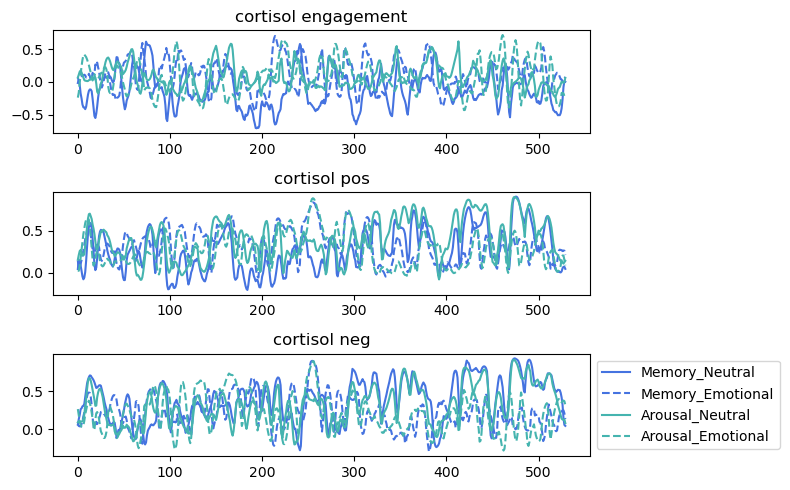

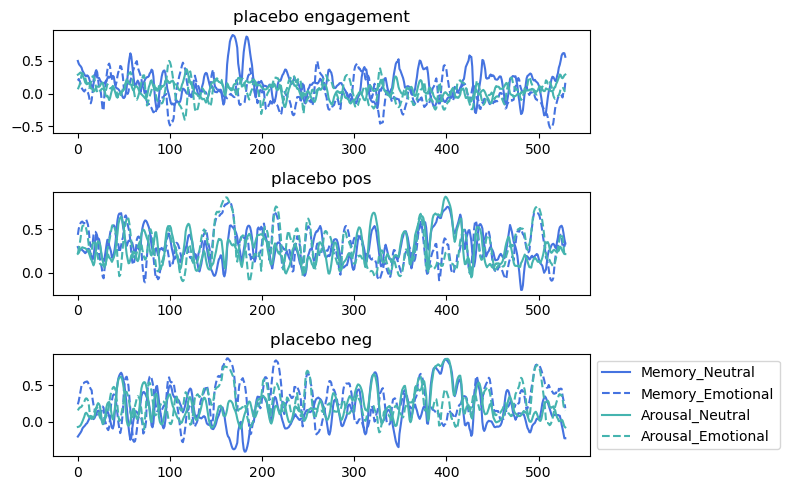

In [25]:
#single subject
# plot difference between pos and neg network
# under cort, arousal network is more active; under plac, memory network is more activate
memory_color = '#4573e0'
arousal_color = '#45b4af'
cortisol_color ='#e06545'
placebo_color = '#b44582'
color_dic={'Arous_All':arousal_color,'RecogAcc_coded':memory_color}
linestyle_dic={'alc':'dashed','tool':'solid'}
cond_ls=['cortisol','placebo']
stim_ls=['tool','alc']
df_ls=[]
for cond in cond_ls:
    fig,axs=plt.subplots(3,1,figsize=(8,5))

    for pheno in ['RecogAcc_coded','Arous_All']:
        for stim in stim_ls:
            sub_ls=['9003']
            conn_ls=[]
            pos_ls=[]
            neg_ls=[]
            for sub in sub_ls:    
                file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_pos_network_strength_perTR.mat'
                data=scipy.io.loadmat(file_path)
                current_pos=data[sub][0]
                
                file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_neg_network_strength_perTR.mat'
                data=scipy.io.loadmat(file_path)
                current_neg=data[sub][0]
                current=current_pos-current_neg
                if np.size(current)<530:
                    current=np.pad(current,(0,530-np.size(current)),'constant',constant_values=np.nan)

                conn_ls.append(current)
                pos_ls.append(current_pos)
                neg_ls.append(current_neg)
            result=np.nanmean(np.array(conn_ls),axis=0)
            axs[0].plot(result,color=color_dic[pheno],linestyle=linestyle_dic[stim])
            axs[0].set_title(cond+' engagement')
            plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),labels=['Memory_Neutral','Memory_Emotional','Arousal_Neutral','Arousal_Emotional'])
            plt.show

            result=np.nanmean(np.array(pos_ls),axis=0)
            axs[1].plot(result,color=color_dic[pheno],linestyle=linestyle_dic[stim])
            axs[1].set_title(cond+' pos')

            plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),labels=['Memory_Neutral','Memory_Emotional','Arousal_Neutral','Arousal_Emotional'])
            plt.show

            result=np.nanmean(np.array(neg_ls),axis=0)
            axs[2].plot(result,color=color_dic[pheno],linestyle=linestyle_dic[stim])
            axs[2].set_title(cond+' neg')
            plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),labels=['Memory_Neutral','Memory_Emotional','Arousal_Neutral','Arousal_Emotional'])
            plt.show

    plt.tight_layout()
    plt.savefig('plots/single_subj_trace_plot'+cond+'.pdf')
    plt.show
                


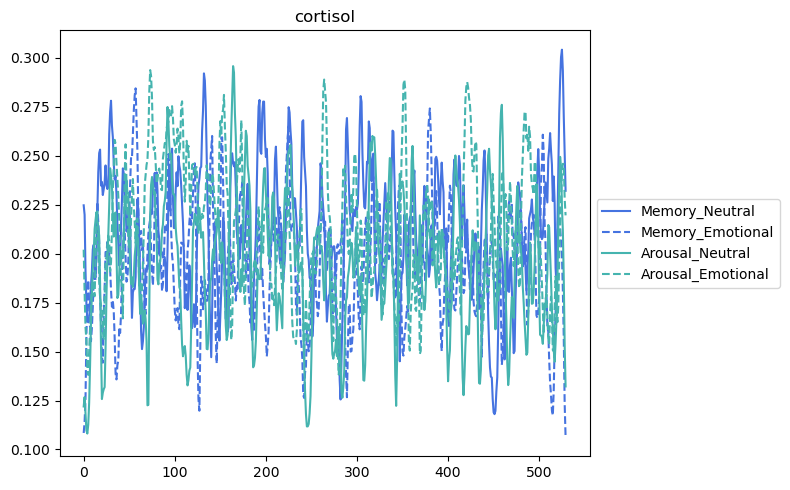

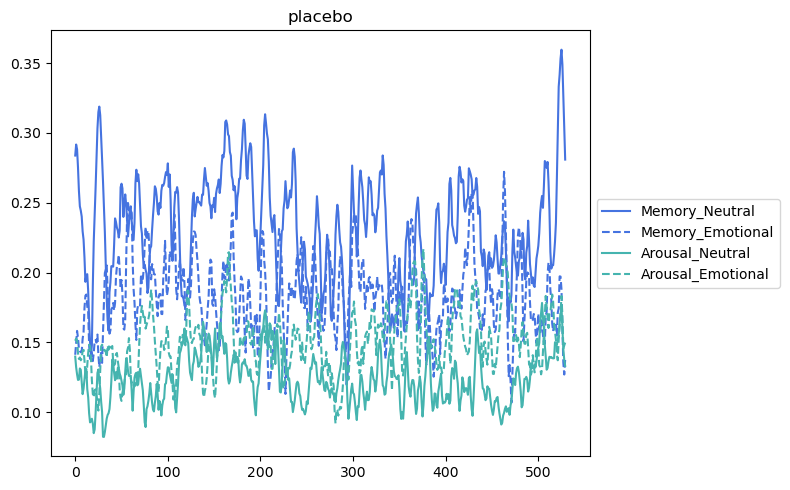

In [5]:
# plot difference between pos and neg network
# under cort, arousal network is more active; under plac, memory network is more activate
memory_color = '#4573e0'
arousal_color = '#45b4af'
cortisol_color ='#e06545'
placebo_color = '#b44582'
color_dic={'Arous_All':arousal_color,'RecogAcc_coded':memory_color}
linestyle_dic={'alc':'dashed','tool':'solid'}
cond_ls=['cortisol','placebo']
stim_ls=['tool','alc']
df_ls=[]
for cond in cond_ls:
    plt.figure(figsize=(8,5))

    for pheno in ['RecogAcc_coded','Arous_All']:
        for stim in stim_ls:
            sub_ls=["9001","9002","9003","9004","9005","9006","9007","9008","9010","9011","9013","9016","9018","9021","9022","9027","9028","9030","9031","9033","9036","9037" ,"9038","9039","9040","9041"]
            
            conn_ls=[]
            for sub in sub_ls:    
                file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_pos_network_strength_perTR.mat'
                data=scipy.io.loadmat(file_path)
                current_pos=data[sub][0]
                
                file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_neg_network_strength_perTR.mat'
                data=scipy.io.loadmat(file_path)
                current_neg=data[sub][0]
                current=abs(current_pos-current_neg)
                if np.size(current)<530:
                    current=np.pad(current,(0,530-np.size(current)),'constant',constant_values=np.nan)

                conn_ls.append(current)
            result=np.nanmean(np.array(conn_ls),axis=0)
            plt.plot(result,color=color_dic[pheno],linestyle=linestyle_dic[stim])
            plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),labels=['Memory_Neutral','Memory_Emotional','Arousal_Neutral','Arousal_Emotional'])

    plt.title(cond)
    plt.tight_layout()
    #plt.savefig('plots/'+cond+'_trace_plot.pdf')
    plt.show
                


In [243]:
cond_ls=['cortisol','placebo']
stim_ls=['alc','tool']
df_ls=[]
for cond in cond_ls:
    for stim in stim_ls:
        for pheno in ['Arous_All','RecogAcc_coded']:
            for direction in ['pos','neg']:
                sub_ls=["9001","9002","9003","9004","9005","9006","9007","9008","9010","9011","9013","9016","9018","9021","9022","9027","9028","9030","9031","9033","9036","9037" ,"9038","9039","9040","9041"]
                cofluc_ls=[]
                for sub in sub_ls:    
                    file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_'+direction+'_network_strength_perTR.mat'
                    data=scipy.io.loadmat(file_path)
                    current=data[sub][0]
                    cofluc_ls.append(np.mean(current))
                print(cond,stim,pheno,direction,np.mean(cofluc_ls))
                df=pd.DataFrame({'conn':cofluc_ls,'sub_id':sub_ls,'Pill':cond,'Stim':stim,'pheno':pheno,'direction':direction})
                df_ls.append(df)

cortisol alc Arous_All pos 0.303738271171009
cortisol alc Arous_All neg 0.2137874197606073
cortisol alc RecogAcc_coded pos 0.3299818902609859
cortisol alc RecogAcc_coded neg 0.24057989784232697
cortisol tool Arous_All pos 0.33227476106526116
cortisol tool Arous_All neg 0.24083259274826757
cortisol tool RecogAcc_coded pos 0.2926891367182034
cortisol tool RecogAcc_coded neg 0.26443883217881897
placebo alc Arous_All pos 0.2528729734450948
placebo alc Arous_All neg 0.2948398172008949
placebo alc RecogAcc_coded pos 0.3080742563827703
placebo alc RecogAcc_coded neg 0.26274789126297876
placebo tool Arous_All pos 0.2959795292043594
placebo tool Arous_All neg 0.26274203003612057
placebo tool RecogAcc_coded pos 0.3197262883550387
placebo tool RecogAcc_coded neg 0.1727693258912038


In [244]:
pd.concat(df_ls).to_csv('data/5s_onward/cofluctuation/summary_table_pos_neg_sep.csv',index=False)

In [12]:
from scipy import stats

cond_ls=['cortisol','placebo']
stim_ls=['alc','tool']
df_ls=[]
for cond in cond_ls:
    for stim in stim_ls:
        sub_ls=["9001","9002","9003","9004","9005","9006","9007","9008","9010","9011","9013","9016","9018","9021","9022","9027","9028","9030","9031","9033","9036","9037" ,"9038","9039","9040","9041"]

        cofluc_ls=[]
        for sub in sub_ls:    
            pheno='Arous_All'
            file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_pos_network_strength_perTR.mat'
            data=scipy.io.loadmat(file_path)
            current_pos=data[sub][0]

            file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_neg_network_strength_perTR.mat'
            data=scipy.io.loadmat(file_path)
            current_neg=data[sub][0]
            current_arous=(current_pos-current_neg)

            pheno='RecogAcc_coded'
            file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_pos_network_strength_perTR.mat'
            data=scipy.io.loadmat(file_path)
            current_pos=data[sub][0]

            file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_neg_network_strength_perTR.mat'
            data=scipy.io.loadmat(file_path)
            current_neg=data[sub][0]
            current_mem=(current_pos-current_neg)

            
            cofluc=np.corrcoef(current_mem,current_arous)[0,1]
            cofluc_ls.append(cofluc)
        df=pd.DataFrame({'cofluc':cofluc_ls,'sub_id':sub_ls,'Pill':cond,'Stim':stim})
        df_ls.append(df)             


In [13]:
pd.concat(df_ls).to_csv('data/5s_onward/cofluctuation/summary_table_pos_neg_diff_corr.csv',index=False)

In [20]:
cond_ls=['cortisol','placebo']
stim_ls=['alc','tool']
df_ls=[]
for cond in cond_ls:
    for stim in stim_ls:
        for pheno in ['Arous_All','RecogAcc_coded']:
            sub_ls=["9001","9002","9003","9004","9005","9006","9007","9008","9010","9011","9013","9016","9018","9021","9022","9027","9028","9030","9031","9033","9036","9037" ,"9038","9039","9040","9041"]
            cofluc_ls=[]
            for sub in sub_ls:    
                file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_pos_network_strength_perTR.mat'
                data=scipy.io.loadmat(file_path)
                current_pos=data[sub][0]
                
                file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_neg_network_strength_perTR.mat'
                data=scipy.io.loadmat(file_path)
                current_neg=data[sub][0]
                cofluc_ls.append(np.mean(current_pos-current_neg))
            print(cond,stim,pheno,np.mean(cofluc_ls))
            df=pd.DataFrame({'pos_neg_diff':cofluc_ls,'sub_id':sub_ls,'Pill':cond,'Stim':stim,'pheno':pheno})
            df_ls.append(df)

cortisol alc Arous_All 0.08995085141040171
cortisol alc RecogAcc_coded 0.08940199241865894
cortisol tool Arous_All 0.0914421683169936
cortisol tool RecogAcc_coded 0.028250304539384406
placebo alc Arous_All -0.04196684375580013
placebo alc RecogAcc_coded 0.04532636511979161
placebo tool Arous_All 0.03323749916823878
placebo tool RecogAcc_coded 0.14695696246383488


In [21]:
pd.concat(df_ls).to_csv('data/5s_onward/cofluctuation/summary_table_pos_neg_diff.csv',index=False)

In [257]:
pheno='Arous_All'
direction='pos'
cond_ls=['cortisol','placebo']
stim_ls=['alc','tool']
df_ls=[]
df_all=pd.read_csv('../data/mem_allsub_alltrial_pill.csv')
timewindow=10
sliding=5
for cond in cond_ls:
    for stim in stim_ls:
        for direction in ['pos','neg']:
            sub_ls=["9001","9002","9003","9004","9005","9006","9007","9008","9010","9011","9013","9016","9018","9021","9022","9027","9028","9030","9031","9033","9036","9037" ,"9038","9039","9040","9041"]
            for sub in sub_ls:    
                df=df_all[(df_all['Subject']==int(sub))&(df_all['Pill']==cond.title())&(df_all['Stim']==stim)]
                df=df.sort_values('Enc_Trial').reset_index(drop=True)

                pheno='RecogAcc_coded'
                file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_'+direction+'_network_strength_perTR.mat'
                data=scipy.io.loadmat(file_path)
                current_mem=data[sub][0]
    
                pheno='Arous_All'
                file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_'+direction+'_network_strength_perTR.mat'
                data=scipy.io.loadmat(file_path)
                current_arous=data[sub][0]
                cofluc_ls=[]
                for t in df['Enc_Trial'].values:
                    #select timewindow for computing connectivity per trial
                    trial_start=df[df['Enc_Trial']==t]['StimOn'].values[0]+sliding
                    mem=current_mem[trial_start:trial_start+timewindow]
                    arous=current_arous[trial_start:trial_start+timewindow]
                    cofluc=np.corrcoef(mem,arous)[0,1]
                    cofluc_ls.append(cofluc)
                df=pd.DataFrame({'cofluc':cofluc_ls,'trial_id':df['Enc_Trial'].values,'sub_id':sub,'Pill':cond,'Stim':stim,'direction':direction})
            df_ls.append(df)

/Users/yhuan256/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/yhuan256/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/yhuan256/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/yhuan256/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/yhuan256/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/yhuan256/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/

In [258]:
pd.concat(df_ls).to_csv('data/5s_onward/cofluctuation/summary_table_byTrial.csv',index=False)

In [259]:
cond_ls=['cortisol','placebo']
stim_ls=['alc','tool']
df_ls=[]
for cond in cond_ls:
    for stim in stim_ls:
        for direction in ['pos','neg']:
            sub_ls=["9001","9002","9003","9004","9005","9006","9007","9008","9010","9011","9013","9016","9018","9021","9022","9027","9028","9030","9031","9033","9036","9037" ,"9038","9039","9040","9041"]
            cofluc_ls=[]
            for sub in sub_ls:    
                pheno='RecogAcc_coded'
                file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_'+direction+'_network_strength_perTR.mat'
                data=scipy.io.loadmat(file_path)
                current_mem=data[sub][0]
                
                pheno='Arous_All'
                file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_'+direction+'_network_strength_perTR.mat'
                data=scipy.io.loadmat(file_path)
                current_arous=data[sub][0]

                cofluc=abs(current_mem-current_arous)
                df=pd.DataFrame({'ps_diff':cofluc,'sub_id':sub,'Pill':cond,'Stim':stim,'direction':direction,'TR':range(len(cofluc))})
                df_ls.append(df)

In [260]:
pd.concat(df_ls).to_csv('data/5s_onward/cofluctuation/summary_table_subtract.csv',index=False)

/var/folders/rz/lxz4z09s59vgs925w6kw_0ns3ygqwl/T/ipykernel_26678/3678091013.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ls=np.concatenate(df[(df['direction']==direction)&(df['Pill']==cond)&(df['Stim']==stim)].groupby('TR').mean().values)


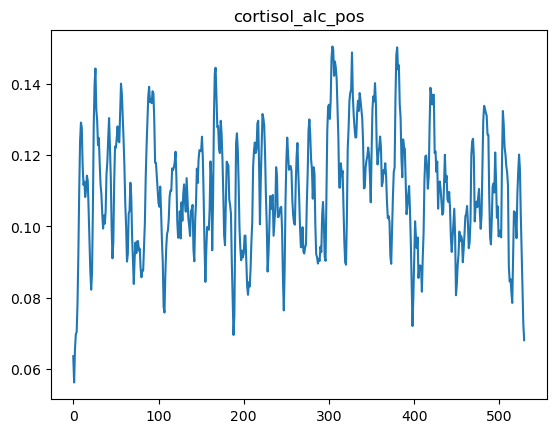

/var/folders/rz/lxz4z09s59vgs925w6kw_0ns3ygqwl/T/ipykernel_26678/3678091013.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ls=np.concatenate(df[(df['direction']==direction)&(df['Pill']==cond)&(df['Stim']==stim)].groupby('TR').mean().values)


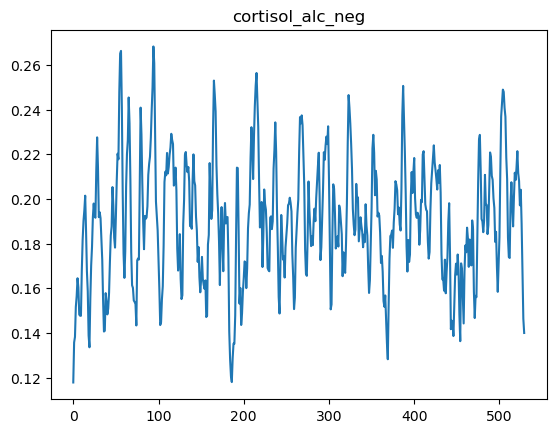

/var/folders/rz/lxz4z09s59vgs925w6kw_0ns3ygqwl/T/ipykernel_26678/3678091013.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ls=np.concatenate(df[(df['direction']==direction)&(df['Pill']==cond)&(df['Stim']==stim)].groupby('TR').mean().values)


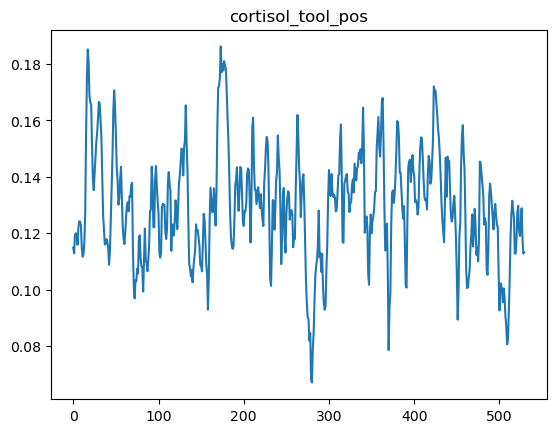

/var/folders/rz/lxz4z09s59vgs925w6kw_0ns3ygqwl/T/ipykernel_26678/3678091013.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ls=np.concatenate(df[(df['direction']==direction)&(df['Pill']==cond)&(df['Stim']==stim)].groupby('TR').mean().values)


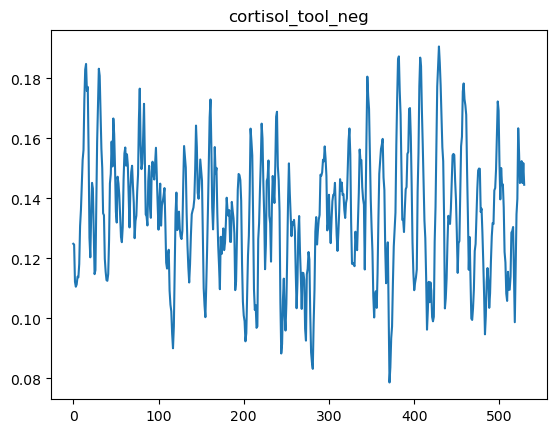

/var/folders/rz/lxz4z09s59vgs925w6kw_0ns3ygqwl/T/ipykernel_26678/3678091013.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ls=np.concatenate(df[(df['direction']==direction)&(df['Pill']==cond)&(df['Stim']==stim)].groupby('TR').mean().values)


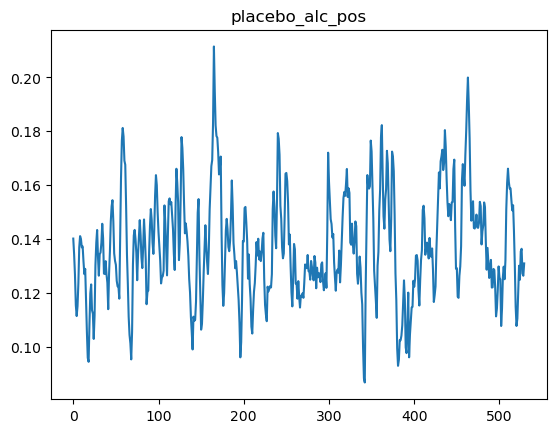

/var/folders/rz/lxz4z09s59vgs925w6kw_0ns3ygqwl/T/ipykernel_26678/3678091013.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ls=np.concatenate(df[(df['direction']==direction)&(df['Pill']==cond)&(df['Stim']==stim)].groupby('TR').mean().values)


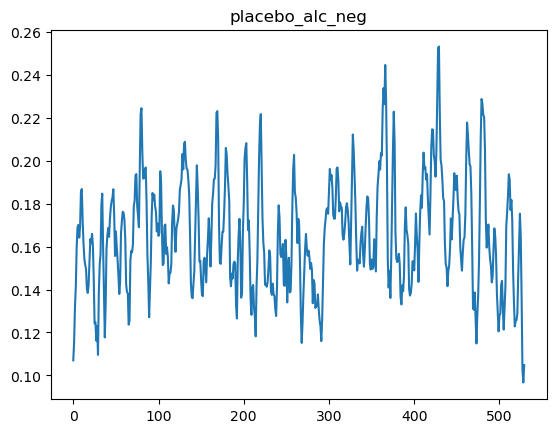

/var/folders/rz/lxz4z09s59vgs925w6kw_0ns3ygqwl/T/ipykernel_26678/3678091013.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ls=np.concatenate(df[(df['direction']==direction)&(df['Pill']==cond)&(df['Stim']==stim)].groupby('TR').mean().values)


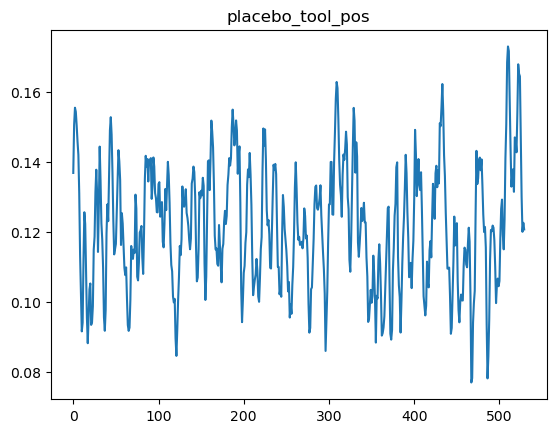

/var/folders/rz/lxz4z09s59vgs925w6kw_0ns3ygqwl/T/ipykernel_26678/3678091013.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ls=np.concatenate(df[(df['direction']==direction)&(df['Pill']==cond)&(df['Stim']==stim)].groupby('TR').mean().values)


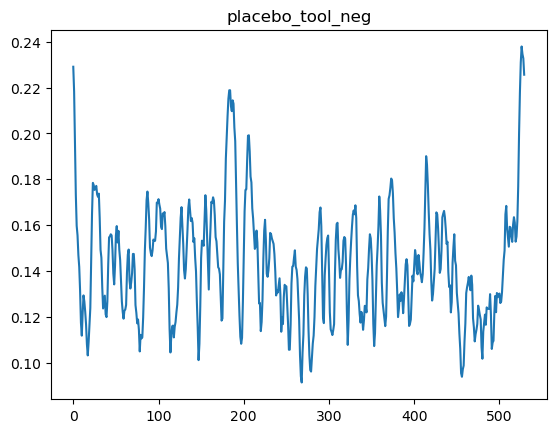

In [33]:
cond_ls=['cortisol','placebo']
stim_ls=['alc','tool']

for cond in cond_ls:
    for stim in stim_ls:
        for direction in ['pos','neg']:
            ls=np.concatenate(df[(df['direction']==direction)&(df['Pill']==cond)&(df['Stim']==stim)].groupby('TR').mean().values)
            plt.plot(ls)

            plt.title(cond+'_'+stim+'_'+direction)
            plt.show()


In [34]:
pheno='Arous_All'
direction='pos'
cond_ls=['cortisol','placebo']
stim_ls=['alc','tool']
df_ls=[]
df_all=pd.read_csv('../data/mem_allsub_alltrial_pill.csv')
timewindow=10
sliding=5
for cond in cond_ls:
    for stim in stim_ls:
        for direction in ['pos','neg']:
            sub_ls=["9001","9002","9003","9004","9005","9006","9007","9008","9010","9011","9013","9016","9018","9021","9022","9027","9028","9030","9031","9033","9036","9037" ,"9038","9039","9040","9041"]
            for sub in sub_ls:    
                df=df_all[(df_all['Subject']==int(sub))&(df_all['Pill']==cond.title())&(df_all['Stim']==stim)]
                df=df.sort_values('Enc_Trial').reset_index(drop=True)

                pheno='RecogAcc_coded'
                file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_'+direction+'_network_strength_perTR.txt'
                data=scipy.io.loadmat(file_path)
                current_mem=data[sub][0]
    
                pheno='Arous_All'
                file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_'+direction+'_network_strength_perTR.txt'
                data=scipy.io.loadmat(file_path)
                current_arous=data[sub][0]
                cofluc_ls=[]
                for t in df['Enc_Trial'].values:
                    #select timewindow for computing connectivity per trial
                    trial_start=df[df['Enc_Trial']==t]['StimOn'].values[0]+sliding
                    mem=current_mem[trial_start:trial_start+timewindow]
                    arous=current_arous[trial_start:trial_start+timewindow]
                    cofluc=np.mean(abs(mem-arous))
                    cofluc_ls.append(cofluc)
                df=pd.DataFrame({'ps_diff':cofluc_ls,'trial_id':df['Enc_Trial'].values,'sub_id':sub,'Pill':cond,'Stim':stim,'direction':direction})
            df_ls.append(df)

/Users/yhuan256/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yhuan256/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/yhuan256/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yhuan256/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [35]:
pd.concat(df_ls).to_csv('data/5s_onward/cofluctuation/summary_table_subtract_byTrial.csv',index=False)

In [36]:
df=pd.concat(df_ls)

/var/folders/rz/lxz4z09s59vgs925w6kw_0ns3ygqwl/T/ipykernel_26678/988368679.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ls=np.concatenate(df[(df['direction']==direction)&(df['Pill']==cond)&(df['Stim']==stim)].groupby('trial_id').mean().values)


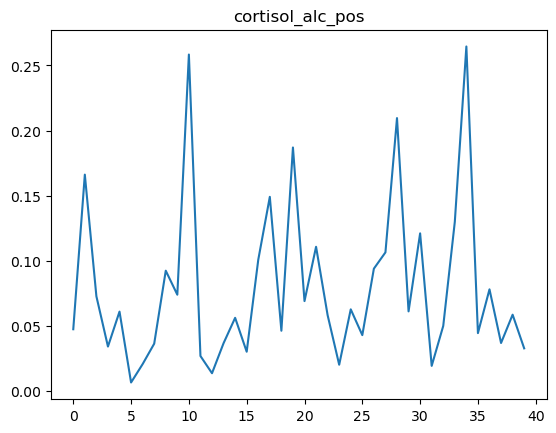

/var/folders/rz/lxz4z09s59vgs925w6kw_0ns3ygqwl/T/ipykernel_26678/988368679.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ls=np.concatenate(df[(df['direction']==direction)&(df['Pill']==cond)&(df['Stim']==stim)].groupby('trial_id').mean().values)


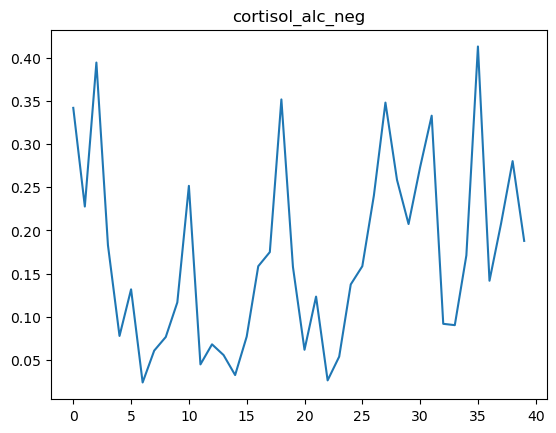

/var/folders/rz/lxz4z09s59vgs925w6kw_0ns3ygqwl/T/ipykernel_26678/988368679.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ls=np.concatenate(df[(df['direction']==direction)&(df['Pill']==cond)&(df['Stim']==stim)].groupby('trial_id').mean().values)


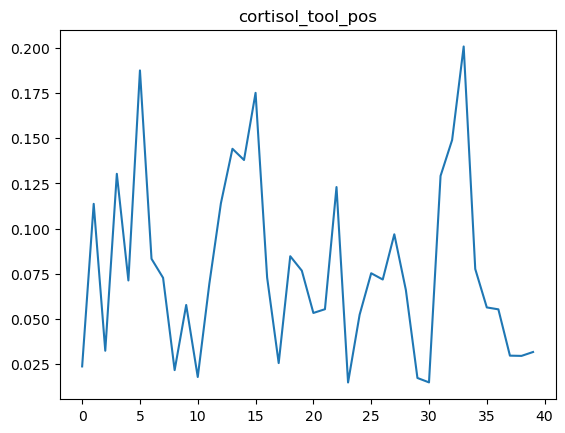

/var/folders/rz/lxz4z09s59vgs925w6kw_0ns3ygqwl/T/ipykernel_26678/988368679.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ls=np.concatenate(df[(df['direction']==direction)&(df['Pill']==cond)&(df['Stim']==stim)].groupby('trial_id').mean().values)


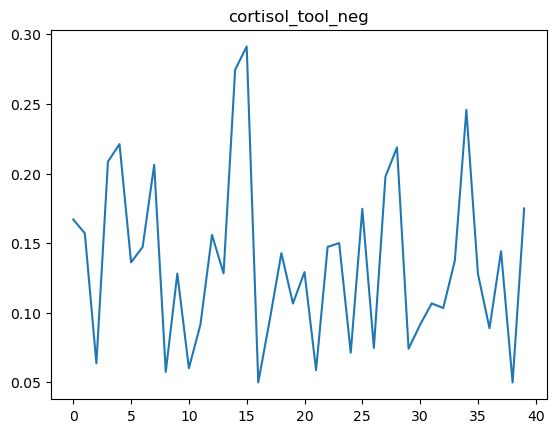

/var/folders/rz/lxz4z09s59vgs925w6kw_0ns3ygqwl/T/ipykernel_26678/988368679.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ls=np.concatenate(df[(df['direction']==direction)&(df['Pill']==cond)&(df['Stim']==stim)].groupby('trial_id').mean().values)


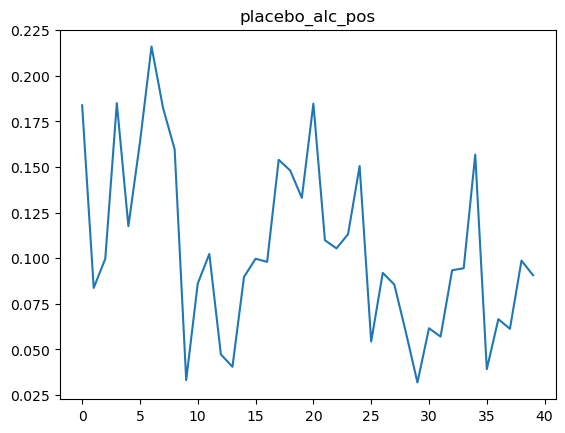

/var/folders/rz/lxz4z09s59vgs925w6kw_0ns3ygqwl/T/ipykernel_26678/988368679.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ls=np.concatenate(df[(df['direction']==direction)&(df['Pill']==cond)&(df['Stim']==stim)].groupby('trial_id').mean().values)


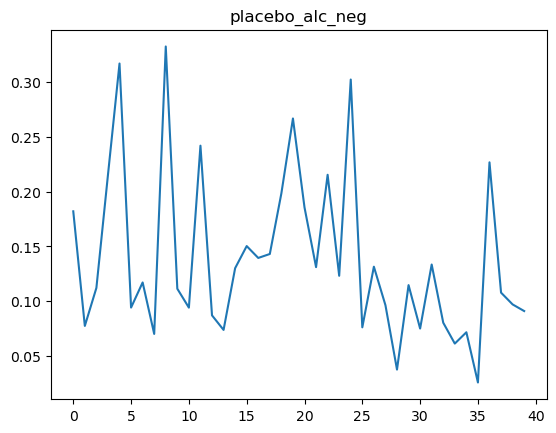

/var/folders/rz/lxz4z09s59vgs925w6kw_0ns3ygqwl/T/ipykernel_26678/988368679.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ls=np.concatenate(df[(df['direction']==direction)&(df['Pill']==cond)&(df['Stim']==stim)].groupby('trial_id').mean().values)


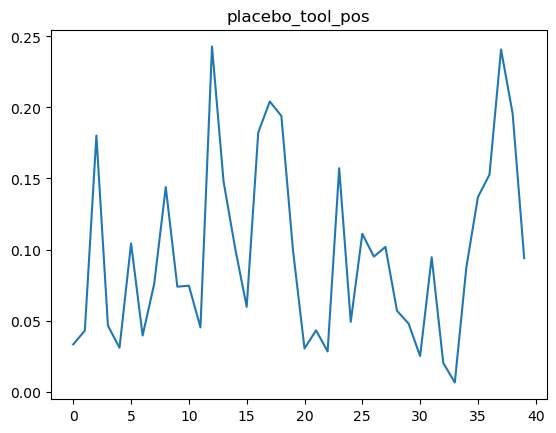

/var/folders/rz/lxz4z09s59vgs925w6kw_0ns3ygqwl/T/ipykernel_26678/988368679.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ls=np.concatenate(df[(df['direction']==direction)&(df['Pill']==cond)&(df['Stim']==stim)].groupby('trial_id').mean().values)


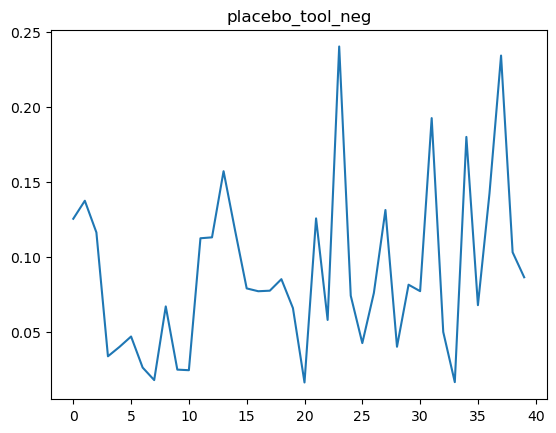

In [37]:
cond_ls=['cortisol','placebo']
stim_ls=['alc','tool']

for cond in cond_ls:
    for stim in stim_ls:
        for direction in ['pos','neg']:
            ls=np.concatenate(df[(df['direction']==direction)&(df['Pill']==cond)&(df['Stim']==stim)].groupby('trial_id').mean().values)
            plt.plot(ls)

            plt.title(cond+'_'+stim+'_'+direction)
            plt.show()


In [14]:
pheno='Arous_All'
direction='pos'
cond_ls=['cortisol','placebo']
stim_ls=['alc','tool']
df_ls=[]
df_all=pd.read_csv('../data/mem_allsub_alltrial_pill.csv')
df_all['RecogAcc_coded']=df_all['RecogAcc'].apply(lambda x:0 if x==4 else x)

timewindow=10
sliding=5
for cond in cond_ls:
    for stim in stim_ls:
        for direction in ['pos','neg']:
            for pheno in ['Arous_All','RecogAcc_coded']:
                sub_ls=["9001","9002","9003","9004","9005","9006","9007","9008","9010","9011","9013","9016","9018","9021","9022","9027","9028","9030","9031","9033","9036","9037" ,"9038","9039","9040","9041"]
                for sub in sub_ls:    
                    df=df_all[(df_all['Subject']==int(sub))&(df_all['Pill']==cond.title())&(df_all['Stim']==stim)]
                    df=df.sort_values('Enc_Trial').reset_index(drop=True)

                    file_path='data/5s_onward/network_strength/'+pheno+'_byTrial_'+cond+'_'+stim+'_htBPfiltered_p0.01_'+direction+'_network_strength_perTR.mat'
                    data=scipy.io.loadmat(file_path)
                    current=data[sub][0]
                    conn_ls=[]
                    for t in df['Enc_Trial'].values:
                        #select timewindow for computing connectivity per trial
                        trial_start=df[df['Enc_Trial']==t]['StimOn'].values[0]+sliding
                        conn=current[trial_start:trial_start+timewindow]
                        conn_ls.append(np.mean(conn))
                    df=pd.DataFrame({'conn':conn_ls,'trial_id':df['Enc_Trial'].values,'sub_id':sub,'Pill':cond,'Stim':stim,'direction':direction,'pheno':pheno,pheno:df[pheno].values})
                    df_ls.append(df)

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [15]:
pd.concat(df_ls).to_csv('data/5s_onward/cofluctuation/summary_table_pos_neg_sep_byTrial.csv',index=False)

In [27]:
df=pd.read_csv('data/5s_onward/cofluctuation/summary_table_pos_neg_sep_byTrial_behaviorFilled.csv')

In [28]:
df

,trial_id,sub_id,Pill,Stim,pheno,pos_conn,neg_conn,conn_diff,Arous_All,RecogAcc_coded
0,1,9001,cortisol,alc,Arous_All,0.249965,0.084319,0.165646,1.0,0.0
1,1,9001,cortisol,alc,RecogAcc_coded,0.273191,0.136009,0.137182,1.0,0.0
2,1,9001,cortisol,tool,Arous_All,0.193427,0.321678,-0.128251,2.0,0.0
3,1,9001,cortisol,tool,RecogAcc_coded,0.161765,0.155520,0.006245,2.0,0.0
4,1,9001,placebo,alc,Arous_All,0.200381,0.277792,-0.077411,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...
8315,40,9041,cortisol,tool,RecogAcc_coded,0.729256,0.586617,0.142639,3.0,0.0
8316,40,9041,placebo,alc,Arous_All,0.482492,0.381715,0.100777,2.0,0.0
8317,40,9041,placebo,alc,RecogAcc_coded,0.492943,0.347992,0.144951,2.0,0.0
8318,40,9041,placebo,tool,Arous_All,0.387801,0.233743,0.154058,3.0,1.0


In [19]:
mem_df[mem_df['Pill']=='cortisol']

NameError: name 'mem_df' is not defined

In [20]:
mem_df=df[df['pheno']=='RecogAcc_coded']
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(x='pos_conn', y='Arous_All', data=mem_df[mem_df['Pill']=='cortisol'], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('positive network strength')
plt.ylabel('Arousal')



KeyError: 'pos_conn'

Text(0, 0.5, 'Arousal')

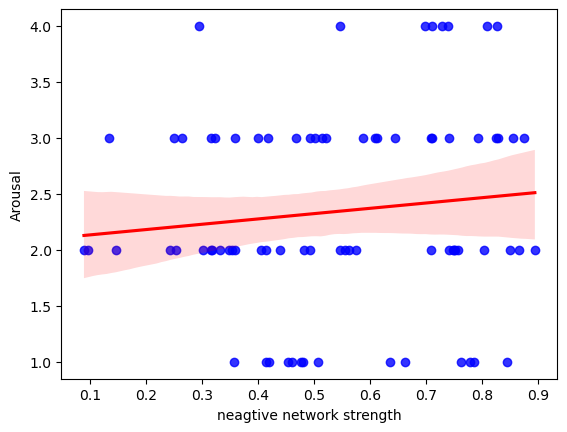

In [32]:
sns.regplot(x='neg_conn', y='Arous_All', data=mem_df[mem_df['Pill']=='cortisol'], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('neagtive network strength')
plt.ylabel('Arousal')

Text(0, 0.5, 'Arousal')

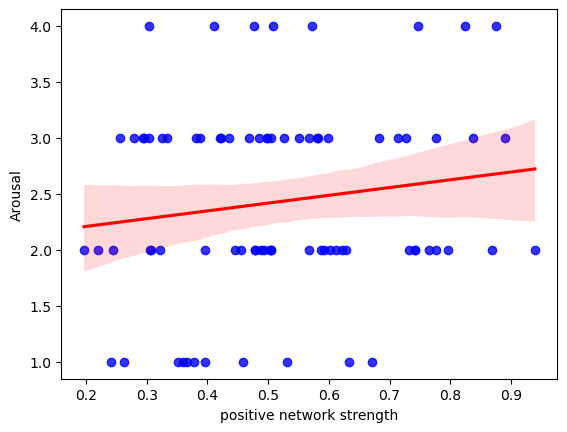

In [28]:
sns.regplot(x='pos_conn', y='Arous_All', data=mem_df[mem_df['Pill']=='placebo'], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('positive network strength')
plt.ylabel('Arousal')



Text(0.5, 1.0, 'Placebo')

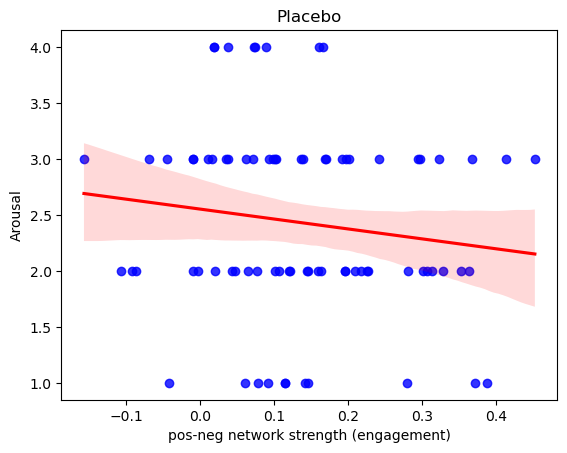

In [37]:
sns.regplot(x='conn_diff', y='Arous_All', data=mem_df[mem_df['Pill']=='placebo'], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('pos-neg network strength (engagement)')
plt.ylabel('Arousal')
plt.title('Placebo')

Text(0.5, 1.0, 'Cortisol')

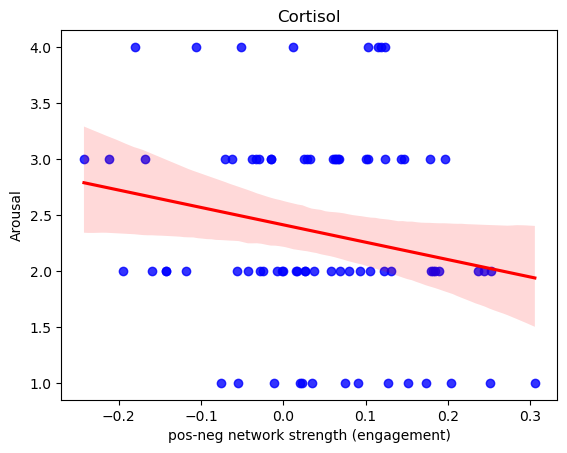

In [38]:
sns.regplot(x='conn_diff', y='Arous_All', data=mem_df[mem_df['Pill']=='cortisol'], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('pos-neg network strength (engagement)')
plt.ylabel('Arousal')
plt.title('Cortisol')

Text(0.5, 1.0, 'Cortisol Emotional Run')

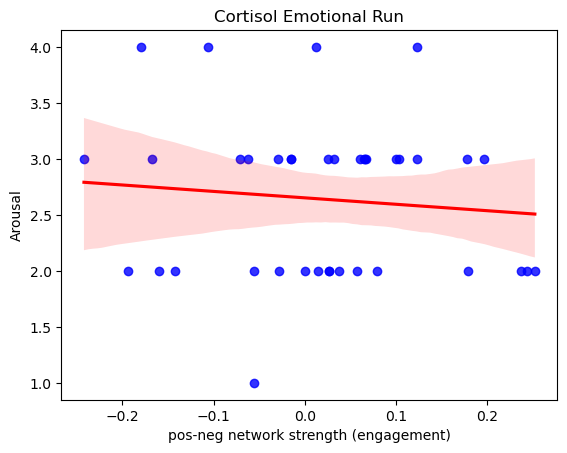

In [51]:
sns.regplot(x='conn_diff', y='Arous_All', data=mem_df[(mem_df['Pill']=='cortisol')&(mem_df['Stim']=='alc')], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('pos-neg network strength (engagement)')
plt.ylabel('Arousal')
plt.title('Cortisol Emotional Run')

Text(0.5, 1.0, 'Cortisol Neutral Run')

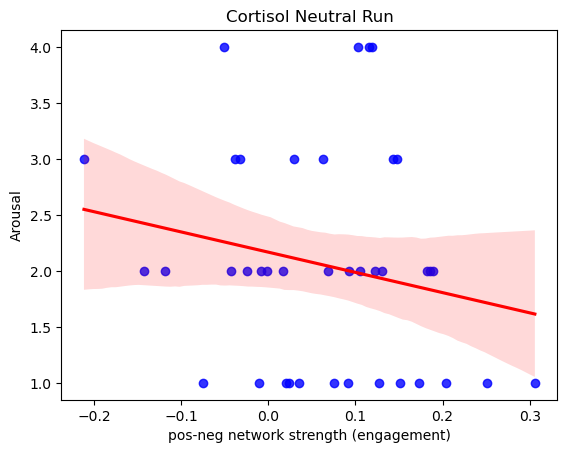

In [52]:
sns.regplot(x='conn_diff', y='Arous_All', data=mem_df[(mem_df['Pill']=='cortisol')&(mem_df['Stim']=='tool')], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('pos-neg network strength (engagement)')
plt.ylabel('Arousal')
plt.title('Cortisol Neutral Run')

Text(0.5, 1.0, 'Placebo Emotional Run')

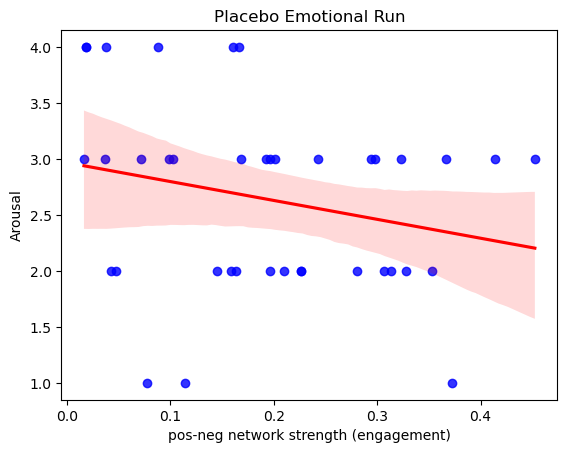

In [55]:
sns.regplot(x='conn_diff', y='Arous_All', data=mem_df[(mem_df['Pill']=='placebo')&(mem_df['Stim']=='alc')], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('pos-neg network strength (engagement)')
plt.ylabel('Arousal')
plt.title('Placebo Emotional Run')

Text(0.5, 1.0, 'Placebo Neutral Run')

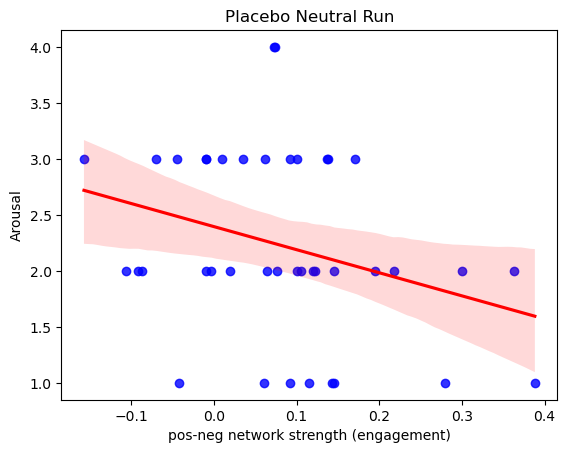

In [56]:
sns.regplot(x='conn_diff', y='Arous_All', data=mem_df[(mem_df['Pill']=='placebo')&(mem_df['Stim']=='tool')], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('pos-neg network strength (engagement)')
plt.ylabel('Arousal')
plt.title('Placebo Neutral Run')